In [1]:
using DifferentialEquations, StatsBase, Statistics, VegaLite, DataFrames, StatsFuns, LinearAlgebra, ForwardDiff, Plots, Roots, BenchmarkTools

In [2]:
struct Actor
    q::Float64       # Efficiency
    o::Float64       # Opportunity cost
    p::Float64       # Price
    δ::Float64       # Discount rate
    f::Float64       # social response strength for fairness
    g::Float64       # social response strength for group identity
    c::Float64       # social response strength for competitiveness
    s::Float64       # social response strength for sustainability
    u::Float64       # social repsonse curvature
    v::Float64       # base Variance in social response
    SN::Array{Float64,1}      # Social Network
    
end

struct Context
#Social:
    N::Int64       # Number of actors
    oM::Float64      # Mean opportunity cost
    oV::Float64      # Variation in opportunity costs
    O::Array{Float64,1}       # Opportunity cost
    D::Array{Float64,2}      # Distances
    F::Float64
    G::Float64
    C::Float64
    S::Float64
    Actors::Array{Actor,1}  # Array of actors
#Ecological:
    r::Float64       # growth rate
    K::Float64       # Carrying Capacity
    description=Dict(:N=>"Number of agents", :oM=>"Median opportunity cost", :oV=>"Variation in opportunity costs")
end

function Actor(;
    q=1.0,
    o=0.1,
    p=1.0,
    δ=0.05,
    f=0.3,
    g=0.0,
    c=0.0,
    s=0.0,
    u=0.1,
    v=0.1,
    SN=[1.0]
    )
    Actor(q,o,p,δ,f,g,c,s,u,v,SN)
end

function Context(;
    N=1,
    oM=0.1,
    oV=0.5,
    O=exp10.(norminvcdf.(collect(range(0.0,stop=1.0,length=N+2))[2:end-1]).*oV.+log10(oM)),
    D=ones(N).-Diagonal(ones(N)),
    r=1.0,
    K=1.0,
    q=1.0,
    p=1.0,
    δ=0.05,
    F=1.0,
    G=0.0,
    C=0.0,
    S=0.0,
    f=0.0,
    g=0.0,
    c=0.0,
    s=0.0,
    u=0.1,
    v=0.1,
    SN=[1.0],
    Actors=[Actor(q[min(end,i)],O[i],p[min(end,i)],δ[min(end,i)],f[min(end,i)],g[min(end,i)],c[min(end,i)],s[min(end,i)],u[min(end,i)],v[min(end,i)],ones(N)) for i in 1:N ],
    )
    Context(N,oM,oV,O,D,F,G,C,S, Actors,r,K)
end

import Base.show

function show(io::IO,a::Actor)
    println(io,"Actor:")
    for s in fieldnames(Actor)
        if size(getfield(a, s),1)>3
            println(io,"  $s = Array"*string(size(getfield(a, s)))*"");
        else
            println(io,"  $s = "*string(getfield(a, s)));
        end
    end
end
        
function show(io::IO,C::Context)
    println(io,"Social:")
    for s in fieldnames(Context)
        s==:r ? println(io,"Ecological: ") : Nothing
        if size(getfield(C, s),1)>3
            println(io,"  $s = Array"*string(size(getfield(C, s)))*"");
        elseif s==:Actors
            q=getfield(C,:N)>1 ? "s" : ""
            println(io,"  "*string(getfield(C,:N))*" Actor$q")
        elseif s==:description
                        
        else
            println(io,"  $s = "*string(getfield(C, s)));
        end
    end
end

show (generic function with 523 methods)

In [4]:
C=Context(N=2)
#C.Actors[1]

Social:
  N = 2
  oM = 0.1
  oV = 0.5
  O = [0.0609027, 0.164196]
  D = [0.0 1.0; 1.0 0.0]
  F = 1.0
  G = 0.0
  C = 0.0
  S = 0.0
  2 Actors
Ecological: 
  r = 1.0
  K = 1.0


In [111]:
function τ(e,p,q,o,X)
    e*p*q*X+(1.0-e)*o
end

function fair(u,e,E,v,V)
    (1.0-exp(u*((e-E)/(v+V))))
end

function group(u,e,E,v,V)
    -(u*(e-E)^2/(v+V))
end

function comp(u,e,E,v,V)
    return (-1.0+exp(u*((e-E)/(v+V))))
end

function sust(e,r,o,K,q,p) #Maximum Economically Sustainable Effort
    #Solve long term optima
    r*(0.5-o/(K*q*p))-e
end

function U(e,q,o,p,E, V, f,g,c,s, u, v, X, r, K)
    τ(e,p,q,o,X)+f*fair(u,e,E,v,V)+g*group(u,e,E,v,V)+c*comp(u,e,E,v,V)+s*sust(e,r,o,K,q,p)
end

function ΔU(e,q,o,p,E, V, f,g,c,s, u, v, X, r, K)
    ForwardDiff.derivative(e -> U(e,q,o,p,E, V, f,g,c,s,u,v,X,r,K), e)
end

ΔU (generic function with 1 method)

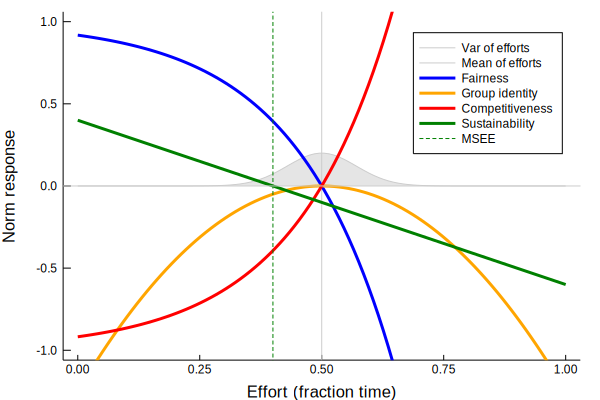

In [185]:
C=Context(N=1)
e=range(0.0,stop=1.0,length=100)
E=0.5
u=1.5
v=0.1
V=0.2
VV=(0.2exp.(-(0.5.-e).^2/(.01)))
plot(e,VV, fill="#ccc",c="#ccc",l=1,ribbon=(0.0,-VV), label="Var of efforts")
vline!([0.5], label="Mean of efforts", c="#ccc")
plot!(e,fair.(u,e,E,v,V), ylim=[-1.0,1.0], c=:blue,label="Fairness", xlabel="Effort (fraction time)", ylabel="Norm response", l=3)
plot!(e,group.(u,e,E,v,V), ylim=[-1.0,1.0], label="Group identity",c=:orange, l=3)
plot!(e,comp.(u,e,E,v,V), ylim=[-1.0,1.0], label="Competitiveness",l=3, c=:red)
plot!(e,sust.(e,C.r,C.Actors[1].o,C.K,C.Actors[1].q,C.Actors[1].p), ylim=[-1.0,1.0], label="Sustainability", c=:green, l=3)


vline!([sust.(0.5-0.5,C.r,C.Actors[1].o,C.K,C.Actors[1].q,C.Actors[1].p)], label="MSEE", c=:green, l=(1,:dash))
hline!([0.0],c="#ccc", label="", grid=false)
#savefig( "norms.png")

In [102]:
function dudt(du,u,C,t)
    e=u[1:end-1]
    X=u[end]
    for i in 1:C.N
        A=C.Actors[i]
        E=sum(A.SN.*e)/sum(A.SN)
        V=sum(A.SN.*(e.-E).^2)/sum(A.SN)
        dU=ΔU(e[i],A.q,A.o,A.p,E, V, C.F+A.f,C.G+A.g,C.C+A.c,C.S+A.s, A.u, A.v, X, C.r, C.K)
        du[i]=dU.+u[i].<0.0 ? -u[i] : dU.+u[i]>1.0 ? 1.0-u[i] : dU
    end
    du[end]=0.001+u[end]*(C.r*(1-u[end]/C.K)-sum(u[1:end-1].*[a.q for a in C.Actors]))
end

dudt (generic function with 1 method)

In [103]:
C=Context(N=30)
u=zeros(C.N+1)
u[end]=1.0
du=similar(u)
t=0.0
@btime dudt(du,u,C,t)

  14.343 μs (96 allocations: 21.97 KiB)


0.001

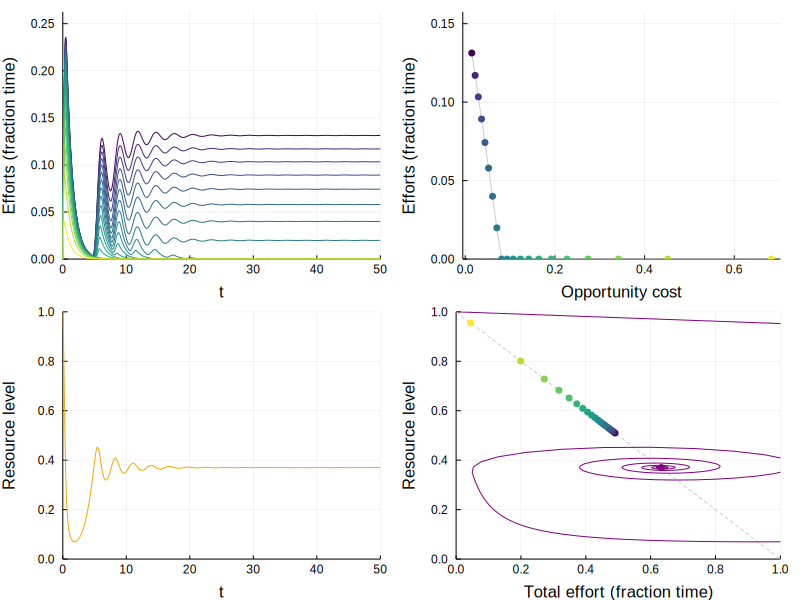

In [188]:
C=Context(N=20,  oV=.5 ,p=1.5,F=0.5, S=0.0)
u=zeros(C.N+1)
u[end]=1.0
du=similar(u)
tspan=(0.0,50.0)
prob = ODEProblem(dudt,u,tspan,C)
sol=solve(prob, saveat=0.1;callback=TerminateSteadyState())
cp=:viridis
oH=[MESE(C.r,a.o,C.K,a.q,a.p) for a in C.Actors]
O=[a.o for a in C.Actors]
p1=plot(sol, vars=1:C.N, label="", ylim=(0.0,maximum(sol.u[end][1:C.N])*2),l=1,color = cp, line_z = log.(O)', ylabel="Efforts (fraction time)", colorbar=false)
p2=plot(C.O,sol.u[end][1:C.N],l=1,c="#ccc", ylim=(0.0,maximum(sol.u[end][1:C.N])*1.2))
scatter!(p2,C.O,sol.u[end][1:C.N], label="", ylabel="Efforts (fraction time)",m=(cp,4),msw=0,zcolor=log.(O), colorbar=false,xlabel="Opportunity cost")


p3=plot(sol, vars=C.N+1, label="", ylim=(0.0,C.K),ylabel="Resource level",l=1, c=:orange)

p4=plot([0.0,1.0],[1.0,0.0], l=:dash,c="#ccc")

scatter!(p4,oH,1.0.-oH,m=(4, cp), msw=0,zcolor=log.(O), colorbar=false)
plot!(p4,[sum(q[1:C.N]) for q in sol.u], [sum(q[C.N+1]) for q in sol.u],c=:purple,xlim=(0.0,1.0),ylim=(0.0,1.0),label="", ylabel="Resource level",xlabel="Total effort (fraction time)")
scatter!(p4,[sum(sol.u[end][1:C.N])],[[sol.u[end][C.N+1]]], label="",msw=0, c=:purple)
plot(p1,p2,p3,p4,layout=(2,2), label="", size=(800,600))
#savefig( "dynamics.png")

In [187]:
sol.u

5001-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]                                                                                                                                                    
 [0.0942449, 0.0935521, 0.0928593, 0.0921558, 0.0914181, 0.0906291, 0.0897728, 0.0888317, 0.0877851, 0.0866075  …  0.0837132, 0.0818881, 0.0796975, 0.0769994, 0.0735609, 0.0689657, 0.0623692, 0.0516725, 0.0291029, 0.923816]                             
 [0.168167, 0.166777, 0.165425, 0.164053, 0.162613, 0.161074, 0.159403, 0.157567, 0.155525, 0.153227  …  0.147578, 0.144016, 0.13974, 0.134473, 0.127759, 0.118785, 0.1059, 0.0849969, 0.0408597, 0.749734]                                                 
 [0.214038, 0.211984, 0.210006, 0.207996, 0.20589, 0.203636, 0.20119, 0.198501, 0.19551, 0.192145  …  0.183872, 0.178653, 0.172388, 0.164669, 0.154828, 0.141671, 0.122731, 0.0920667, 0.037257, 0.56435]

In [ ]:

#This uses julia dispatch to be able to use method based on input type
function U(e,z::par)
    U.(e,z.q,z.O,z.p,z.E, z.V, z.f,z.g,z.c,z.s, z.u, z.v, z.X, z.r, z.K)
end

function ΔU(e::Float64,z::par)
    ForwardDiff.derivative(e -> U.(e,z.q,z.O,z.p,z.E, z.V, z.f,z.g,z.c,z.s, z.u, z.v, z.X, z.r, z.K), e)
end

# a little julia tricks are needded to make this working very efficiently for arrays
function ΔU(e::Array{Float64,1},z::par)
    [ForwardDiff.derivative(e -> U.(e,z.q[min(end,i)],z.O[min(end,i)],z.p[min(end,i)],z.E[min(end,i)], z.V[min(end,i)], z.f[min(end,i)],z.g[min(end,i)],z.c[min(end,i)],z.s[min(end,i)], z.u[min(end,i)], z.v[min(end,i)], z.X[min(end,i)], z.r[min(end,i)], z.K[min(end,i)]), e[i]) for i in 1:length(e)]
end

function findZero()
    eZ=try find_zero(Δe, (0,1), Bisection()) catch NaN end
    typeof(Z)==Nothing ? Z=0.0 : Nothing
end

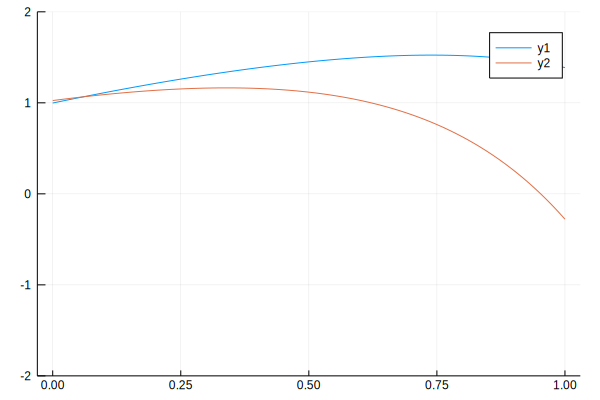

In [9]:
z=par(N=1, u=0.1,v=0.2, g=1.0,V=0.1)
e=range(0.0,stop=1.0,length=100)
V=range(0.0,stop=1.0,length=100)
plot(e,U(e,par(N=1, E=0.5,u=0.1,v=0.2, g=1.0,V=0.1)), ylim=(-2,2))
plot!(e,U(e,par(N=1, E=0.1, u=0.1,v=0.2, g=1.0,V=0.1)), ylim=(-2,2))

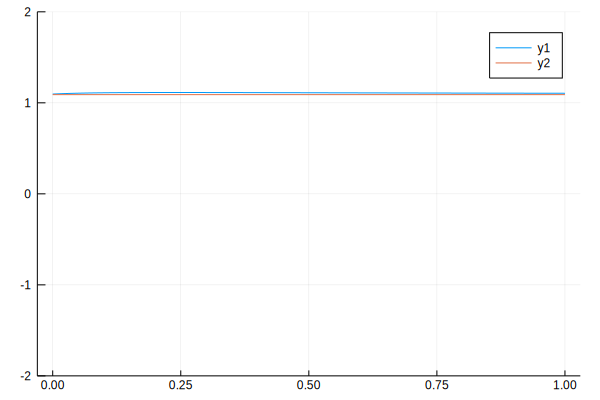

In [10]:
z=par(N=1, u=0.1,v=0.2, g=1.0,V=0.1)
e=0.1
V=range(0.0,stop=1.0,length=100)
plot(V,U(e,par(N=1, E=0.5,u=0.1,v=0.2, g=1.0,V=V)), ylim=(-2,2))
plot!(V,U(e,par(N=1, E=0.1, u=0.1,v=0.2, g=1.0,V=V)), ylim=(-2,2))

In [11]:
z=par(N=10, p=1.0, v=0.1)
q=z.q; o=z.O[1]; p=z.p ; f=z.f;g=z.g;c=z.c;s=z.s; u=z.u; v=z.v; r=z.r; K=z.K
e=0.1; X=0.5; E=0.2; V=0.1

U(e,q,o,p,E, V, f,g,c,s, u, v, X, r, K)

1.0555266251454456

In [68]:
]add DiffEqCallbacks

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...


┌ Warning: julia version requirement for package BioTools not satisfied
└ @ Pkg.Operations /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Pkg/src/Operations.jl:153


 Installed SoftGlobalScope ─────── v1.0.8
 Installed FunctionalCollections ─ v0.5.0
 Installed LazyArrays ──────────── v0.5.1
 Installed RecursiveArrayTools ─── v0.18.5
 Installed TextParse ───────────── v0.6.2
 Installed StochasticDiffEq ────── v5.10.3
 Installed NLSolversBase ───────── v7.1.2
 Installed Cassette ────────────── v0.2.0
 Installed CMake ───────────────── v1.1.1
 Installed TableTraits ─────────── v0.4.1
 Installed FillArrays ──────────── v0.4.0
 Installed OrdinaryDiffEq ──────── v4.18.3
  Updating `~/.julia/environments/v1.0/Project.toml`
  [459566f4] + DiffEqCallbacks v2.4.0
  Updating `~/.julia/environments/v1.0/Manifest.toml`
  [631607c0] ↑ CMake v1.1.0 ⇒ v1.1.1
  [7057c7e9] ↑ Cassette v0.1.4 ⇒ v0.2.0
  [1a297f60] ↑ FillArrays v0.3.0 ⇒ v0.4.0
  [de31a74c] ↑ FunctionalCollections v0.4.0 ⇒ v0.5.0
  [5078a376] ↑ LazyArrays v0.5.0 ⇒ v0.5.1
  [d41bc354] ↑ NLSolversBase v7.1.1 ⇒ v7.1.2
  [1dea7af3] ↑ OrdinaryDiffEq v4.18.2 ⇒ v4.18.3
  [731186ca] ↑ RecursiveArrayTools v0.18.

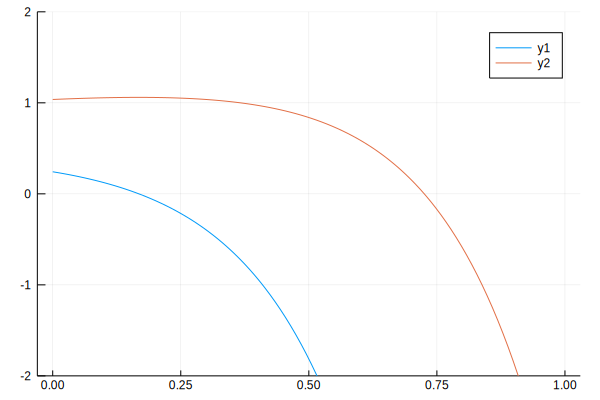

In [13]:
e=range(0.0,stop=1.0,length=100)
out=[ΔU(ϵ,q,o,p,E, V, f,g,c,s, u, v, X, r, K) for ϵ in e]
out2=[U(ϵ,q,o,p,E, V, f,g,c,s, u, v, X, r, K) for ϵ in e]
plot(e,out, ylim=(-2,2))
plot!(e,out2)

In [20]:
function hasZero(q::Float64,o::Float64,p::Float64,E::Float64, V::Float64, f::Float64,g::Float64,c::Float64,s::Float64, u::Float64, v::Float64, X::Float64, r::Float64, K::Float64, min_e::Float64, max_e::Float64, N_e::Int64)
    e=range(min_e,stop=max_e,length=N_e)
    q=[ΔU(ϵ,q,o,p,E, V, f,g,c,s, u, v, X, r, K) for ϵ in e]
    (v,i)=findmin(q.^2)
    return max(1,i-1),i,min(N_e,i+1),e[max(1,i-1)],e[i],e[min(N_e,i+1)]
end
o=0.2
N_e=4
il,im,ir,vl,vm,vr=hasZero(q,o,p,E, V, f,g,c,s, u, v, X, r, K,0.0,1.0,N_e)
i1,i2,i3,v1,v2,v3=hasZero(q,o,p,E, V, f,g,c,s, u, v, X, r, K,vl,vr,N_e)
i1,i2,i3,v1,v2,v3=hasZero(q,o,p,E, V, f,g,c,s, u, v, X, r, K,vl,vr,N_e)
@btime hasZero(q,o,p,E, V, f,g,c,s, u, v, X, r, K,0.0,1.0,N_e)

  2.731 μs (79 allocations: 1.84 KiB)


(1, 1, 2, 0.0, 0.0, 0.3333333333333333)

In [98]:
using ForwardDiff, BenchmarkTools

mutable struct pa
    a::Float64
    b::Float64
end

mutable struct pb
    a::Union{Float64, Array{Float64,1}}
    b::Union{Float64, Array{Float64,1}}
end

mutable struct pc
    a::Array{Float64,1}
    b::Array{Float64,1}
end

mutable struct px
    a
    b
end

pA=pa(0.3,0.2)
pB=pb(0.3,[0.3, 0.2])
pC=pc([0.9, 0.3],[0.3, 0.2])

pX1=px(0.3,0.2)
pX2=px(0.3,[0.3, 0.2])
pX3=px([0.9, 0.3],[0.3, 0.2])

function U(x,a,b)
    x+(a*x)^2*b*x
end

function UA(x,p::pa)
    U.(x,p.a,p.b)
end

function UB(x,p::pb)
    U.(x,p.a,p.b)
end

function UC(x,p::pc)
    U.(x,p.a,p.b)
end

function UX(x,p::px)
    U.(x,p.a,p.b)
end

function ΔUA(x,p)
    ForwardDiff.derivative.(x -> UA(x,p), x)
end

function ΔUB(x,p)
    ForwardDiff.derivative.(x -> UB(x,p), x)
end

function ΔUC(x,p)
    ForwardDiff.derivative.(x -> UC(x,p), x)
end

function ΔUX(x,p)
    ForwardDiff.derivative.(x -> UX(x,p), x)
end

function ΔUX(x::Array{Float64,1},p)
    ForwardDiff.derivative.(x -> UX(x,p), x)
end

x=0.1; X=[0.1,0.2]

@btime UA(x,pA)
@btime UB(x,pB)
@btime UC(x,pC)
@btime UX(x,pX1)
@btime UX(x,pX2)
@btime UX(x,pX3)
#UA.(X,pA)

  19.838 ns (1 allocation: 16 bytes)
  410.608 ns (5 allocations: 208 bytes)
  354.126 ns (2 allocations: 128 bytes)
  279.000 ns (4 allocations: 96 bytes)
  725.269 ns (5 allocations: 192 bytes)
  781.383 ns (5 allocations: 192 bytes)


2-element Array{Float64,1}:
 0.100243           
 0.10001800000000001

In [54]:
@btime UA(X,pA)
@btime [UA(X[1],pA),UA(X[2],pA)]
@btime UB(X,pB)
@btime UC(X,pC)
@btime UX(X,pX1)
@btime UX(X,pX2)
@btime UX(X,pX3)

  344.382 ns (2 allocations: 128 bytes)
  134.007 ns (5 allocations: 160 bytes)
  407.030 ns (5 allocations: 208 bytes)
  330.864 ns (2 allocations: 128 bytes)
  712.438 ns (4 allocations: 176 bytes)
  775.551 ns (4 allocations: 176 bytes)
  906.700 ns (4 allocations: 176 bytes)


2-element Array{Float64,1}:
 0.100243           
 0.20014400000000002

In [51]:
@btime ΔUA(x,pA)
@btime ΔUB(x,pB)
@btime ΔUC(x,pC)
@btime ΔUX(x,pX1)
@btime ΔUX(x,pX2)
@btime ΔUX(x,pX3)

  35.416 ns (4 allocations: 64 bytes)
  511.335 ns (7 allocations: 352 bytes)
  388.429 ns (6 allocations: 288 bytes)
  567.812 ns (5 allocations: 176 bytes)
  1.019 μs (7 allocations: 352 bytes)
  1.091 μs (7 allocations: 352 bytes)


2-element Array{Float64,1}:
 1.00729
 1.00054

In [52]:
@btime ΔUA(X,pA)
@btime ΔUB(X,pB)
@btime ΔUC(X,pC)
@btime ΔUX(X,pX1)
@btime ΔUX(X,pX2)
@btime ΔUX(X,pX3)

  48.634 ns (2 allocations: 112 bytes)
  1.200 μs (21 allocations: 944 bytes)
  699.248 ns (10 allocations: 624 bytes)
  1.329 μs (17 allocations: 592 bytes)
  2.361 μs (21 allocations: 944 bytes)
  2.473 μs (21 allocations: 944 bytes)


2-element Array{Array{Float64,1},1}:
 [1.00729, 1.00054]
 [1.02916, 1.00216]

In [53]:
println(typeof(ΔUA(X,pA)))
println(typeof(ΔUB(X,pB)))
println(typeof(ΔUC(X,pC)))
println(typeof(ΔUX(X,pX1)))
println(typeof(ΔUX(X,pX2)))
println(typeof(ΔUX(X,pX3)))

Array{Float64,1}
Array{Array{Float64,1},1}
Array{Array{Float64,1},1}
Array{Float64,1}
Array{Array{Float64,1},1}
Array{Array{Float64,1},1}


2-element Array{Array{Float64,1},1}:
 [1.00729, 1.00054]
 [1.02916, 1.00216]

In [9]:
p=par(N=10);p.s=[1.0,0.0,0.5]; p.p=10.0; p.O=p.O; p.e.*=0.5; p.v=0.2; p.X=0.5
P=p
function Δe(ϵ,p)
    ForwardDiff.derivative.(x -> U(x,p), ϵ)
end
e=range(0.0,stop=1.0,length=100)
u=[U(ϵ,p)[1] for ϵ in e]
du=[ForwardDiff.derivative.(x -> U(x,p), ϵ)[1] for ϵ in e]
g=[group(ϵ,p)[1] for ϵ in e]
fa=[fair(ϵ,p)[1] for ϵ in e]
Z=try find_zero(Δe, (0,1), Bisection()) catch NaN end
typeof(Z)==Nothing ? Z=0.0 : Nothing
plot(e,du)
plot!(e,u, ylim=(-1.0,2.0))
scatter!([Z],[0.0], label="")
scatter!([Z],[U(Z,p)[1]], label="")

UndefVarError: UndefVarError: par not defined

In [6]:
function dudt(du,u,p,t)
    p.e=u[1:end-1]
    p.X=u[end]
    for i in 1:p.N
       Δϵ=Δe(u[1:p.N],p)
       du[i]= Δϵ+u[i]<0.0 ? -u[i] : Δϵ+u[i]>1.0 ? 1.0-u[i] : Δϵ # ensures effort stays within [0.0, 1.0]
    end
    du[end]=0.001+p.r*u[end]*((1-u[end]/p.K)-u[end]*p.q*sum(u[1:end-1]))
end
u=vcat(P.e,P.X)
P.e

function dudt(du,u,p,t)
    p.e=u[1:end-1]
    p.X=u[end]
    Δϵ=Δe(u[1:p.N],p)
    du[1:p.N]=Δϵ.+u[1:p.N].<0.0 ? -u[1:p.N] : Δϵ.+u[1:p.N]>1.0 ? 1.0-u[1:p.N] : Δϵ # ensures effort stays within [0.0, 1.0]
    du[end]=0.001+p.r*u[end]*((1-u[end]/p.K)-u[end]*p.q*sum(u[1:end-1]))
end
P

UndefVarError: UndefVarError: P not defined

In [7]:
P=par(N=2, v=0.5, p=10.0, X=0.9)
P.s=[0.0,1.0,0.0]
u=vcat(P.e,P.X)
du=similar(u)
tspan=(0.0,10.0)
prob = ODEProblem(dudt,u,tspan,P)
sol=solve(prob)
plot(sol)

UndefVarError: UndefVarError: Δe not defined

In [8]:
P=par(N=2, v=0.5, p=10.0, X=0.9)
P.s=[0.0,1.0,0.0]

3-element Array{Float64,1}:
 0.0
 1.0
 0.0

In [9]:
sol.u[i]
du=similar(sol.u[i])
dudtx(du,u,P,0.0)
du


UndefVarError: UndefVarError: sol not defined

In [10]:
i=2
Δe(u[1:2],P)

UndefVarError: UndefVarError: Δe not defined

In [11]:
U(u[1:2],P)

2-element Array{Float64,1}:
 0.09055809334111413
 0.11042635319553396

In [12]:
u[1]=0.1
ϵ=0.1
[ForwardDiff.derivative.(x -> U(x,P), ϵ) for ϵ in u[1:2]]

2-element Array{Array{Float64,1},1}:
 [8.50944, 8.48957]
 [8.90944, 8.88957]

In [13]:
u

3-element Array{Float64,1}:
 0.1
 0.0
 0.9

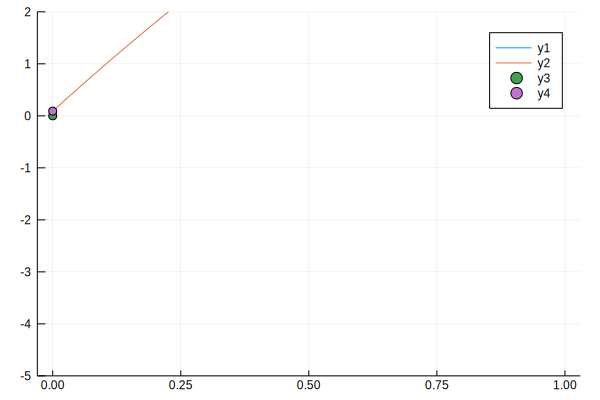

In [14]:
e=range(0.0,stop=1.0,length=100)
P.p=10
u=[U(ϵ,P)[1] for ϵ in e]
du=[ForwardDiff.derivative.(x -> U(x,P), ϵ)[1] for ϵ in e]
g=[group(ϵ,P)[1] for ϵ in e]
fa=[fair(ϵ,P)[1] for ϵ in e]
Z=try find_zero(Δe, (0,1), Bisection()) catch NaN end
typeof(Z)==Nothing ? Z=0.0 : Nothing
plot(e,du)
plot!(e,u, ylim=(-5.0,2.0))
scatter!([Z],[0.0])
scatter!([Z],[U(Z,P)[1]])

In [15]:
Δe(0.0,P)

UndefVarError: UndefVarError: Δe not defined

In [16]:
P.v

0.5

In [17]:
P=par(N=2)
u=zeros(P.N+1)
u[1:P.N].=P.e
u[end]=P.X
du=similar(u)
tspan=(0.0,100.0)
prob = ODEProblem(dudt,u,tspan,P)
sol=solve(prob)

UndefVarError: UndefVarError: Δe not defined

In [18]:
function Δe(ϵ,p)
    ForwardDiff.derivative.(x -> U(x,p), ϵ)[1]
end

Δe (generic function with 1 method)

In [19]:
P.e=collect(range(0.0,stop=1.0,length=P.N))
[Δe(ϵ,P) for ϵ in P.e]

2-element Array{Float64,1}:
   0.22472465968238364
 -11.012654903621389  

In [20]:
P.e

2-element Array{Float64,1}:
 0.0
 1.0

In [21]:
P=par(N=10)

N = 10
e = Array(10,)
q = 1.0
oM = 0.1
oV = 0.1
O = Array(10,)
p = 1.0
δ = 0.05
E = 0.0
V = 0.0
s = [1.0, 0.0, 0.0]
u = 1.0
v = 0.1
X = 1.0
r = 1.0
K = 1.0
SN = Array(10, 10)
TN = Array(10, 10)


In [22]:
P.e

10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [23]:
ϵ=0.1    
N,e,q,oM,oV,O,p,δ, E, V, s, u, v, X, r, norm, SN, TN = unpack(P)
    de=ϵ-mean(e)
    V=mean((mean(e).-e).^2)
    return -s[2]*(u*Δe.^2/(v+V))

BoundsError: BoundsError: attempt to access (10, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1.0, 0.1, 0.1, [0.073533, 0.0811249, 0.0870044, 0.0922836, 0.097405, 0.102664, 0.108362, 0.114937, 0.123267, 0.135993], 1.0, 0.05, 0.0, 0.0, [1.0, 0.0, 0.0], 1.0, 0.1, 1.0, 1.0, [0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0], [0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0])
  at index [18]

In [24]:
-s[2]*(u*de.^2)

UndefVarError: UndefVarError: de not defined

In [25]:
s

3-element Array{Float64,1}:
 1.0
 0.0
 0.0

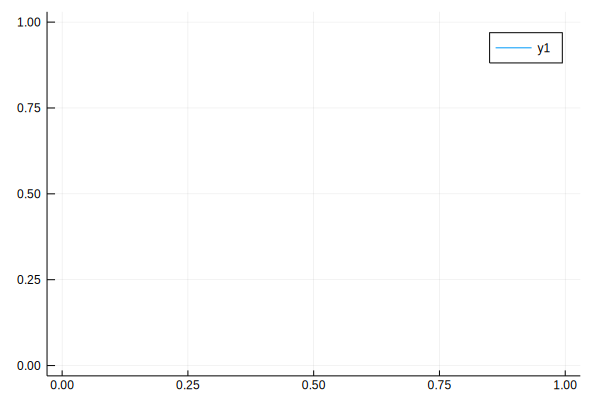

In [26]:
k=0.3
l=2
plot(e,sign.((e.-E)).*k.*abs.(e.-E).^l./(k.^l.+abs.(e.-E).^l))

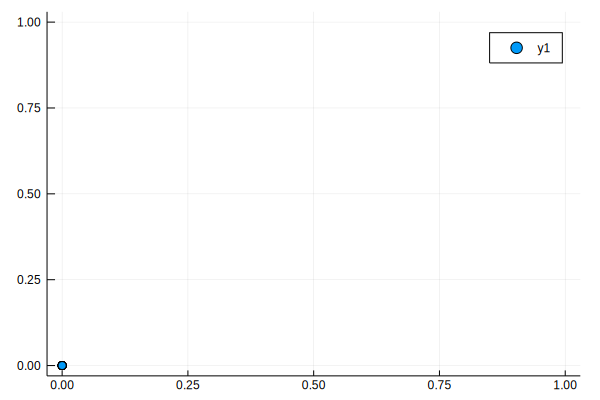

In [27]:
k=0.1
l=1
scatter(e,sign.(tan.(e.-E)))

In [ ]:
mutable struct par
    N       # Number of actors

    e       # Effort (time)
    q       # Efficiency
    oM      # Mean opportunity cost
    oV      # Variation in opportunity costs
    O       # Opportunity cost
    p       # Price
    δ       # Discount rate

    E       # Mean Effort
    V       # Variation in Effort
    f       # social response strength for fairness
    g       # social response strength for group identity
    c       # social response strength for competitiveness
    s       # social response strength for sustainability
    u       # social repsonse curvature
    v       # base Variance in social response

    X       # Stock
    r       # growth rate
    K       # Carrying Capacity

    SN      # Social Network
    TN      # Spatial Network
end

function par(;
    N=1,
    e=zeros(N),
    q=1.0,
    oM=0.1,
    oV=0.1,
    O=exp10.(norminvcdf.(collect(range(0.0,stop=1.0,length=N+2))[2:end-1]).*oV.+log10(oM)),
    p=1.0,
    δ=0.05,
    E=0.0,
    V=0.0,
    f=1.0,
    g=0.0,
    c=0.0,
    s=0.0,
    u=0.1,
    v=0.1,
    X=1.0,
    r=1.0,
    K=1.0,
    SN=ones(N).-Diagonal(ones(N)),
    TN=ones(N).-Diagonal(ones(N))
    )
    par(N,e,q,oM,oV,O,p,δ,E,V,f,g,c,s,u,v,X,r,K,SN,TN)
end



function unpack(p::par)
    #N,e,q,oM,oV,O,p,δ, E, V, s, u, v, X, r, SN, TN = unpack(p)
    return p.N,p.e,p.q,p.oM,p.oV,p.O,p.p,p.δ, p.E, p.V, p.f,p.g,p.c,p.s, p.u, p.v, p.X, p.r,  p.SN, p.TN
end

import Base.show
function show(io::IO,p::par)
    for s in fieldnames(par)
        if size(getfield(p, s),1)>3
            println(io,"$s = Array"*string(size(getfield(p, s)))*"");
        else
            println(io,"$s = "*string(getfield(p, s)));
        end
    end
end